In [113]:
import os 
import cv2 
import numpy as  np 
import matplotlib.pyplot as plt 
import keras 

from keras import layers, optimizers, regularizers
from keras.optimizers import adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, ZeroPadding2D, MaxPooling2D

from keras.preprocessing.image import ImageDataGenerator 
from keras.optimizers import SGD 
from keras import callbacks, losses, models
from keras.layers import  BatchNormalization
import matplotlib.image as mpimg


from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)


### Read file path 

In [102]:
img_fps_train  = '/home/manhduy/Documents/model_DL/Project_Intern/Data/102_flower_dataset/train'
img_fps_test   = '/home/manhduy/Documents/model_DL/Project_Intern/Data/102_flower_dataset/test'
img_fps_validation = '/home/manhduy/Documents/model_DL/Project_Intern/Data/102_flower_dataset/valid'

In [103]:
def wfile(path_folder ): 
    fp = []
    for path, subdir, file in os.walk(path_folder): 
        for name in file: 
            fp.append(os.path.join(path,name))
    return sorted(fp)

In [104]:
x_train = wfile(img_fps_train)
x_valid = wfile(img_fps_validation)
x_test  = wfile(img_fps_test)

In [105]:
labels_train = []
labels_valid = []
labels_test  = []

for path in x_train: 
    labels_train.append( int(path.split("/")[-2])-1)
for path in x_valid: 
    labels_valid.append( int(path.split("/")[-2])-1)
for path in x_test: 
    labels_test.append(  int(path.split("/")[-2])-1)

In [106]:
len(x_train),len(labels_train),len(x_test),len(labels_test),len(x_valid),len(labels_valid)

(17071, 17071, 1486, 1486, 2435, 2435)

### Data Generator

In [125]:
class Generator_Augmentation(keras.utils.Sequence): 
    """data generator for classifiction"""
    def __init__(self,
                 root_file, 
                 label, 
                 batch_size = 8, 
                 img_shape = (224,224), 
                 no_channels = 3, 
                 no_classes = 102, 
                 augmentation = True,
                 shuffle = True): 
    
        self.img_shape = img_shape 
        self.no_channels = no_channels
        self.no_classes = no_classes 
        self.batch_size = batch_size 

        self.augmentation = augmentation 

        self.root_file = root_file 
        self.label = label 
        
        print(" >>>>>>> batch_size : {} image".format(self.batch_size))
        self.ids = range(len(self.root_file))   # len cua file data. 
        assert len(self.root_file) == len(self.label)
        self.shuffle = shuffle 
        self.on_epoch_end() 

        
    def __len__(self): 
        return int(np.floor(len(self.ids) / self.batch_size))
    
    def __getitem__(self, index): 
        indexes_array = self.indexes_array[index*self.batch_size : (index + 1) * self.batch_size]
#         print(index)
#         print(indexes_array)
        
        array_ids = [self.ids[k] for k in indexes_array]
#         print(array_ids)
        x, y = self.__data_generator(array_ids)
        
        return x, y 
    
    def on_epoch_end(self): 
        self.indexes_array = np.arange(len(self.ids))
        if self.shuffle: 
            np.random.shuffle(self.indexes_array)
    
      
    
    def strong_aug(self,p=0.5):
        return Compose([
            RandomRotate90(),
            Flip(),
            Transpose(),
            OneOf([
                IAAAdditiveGaussianNoise(),
                GaussNoise(),
            ], p=0.2),
            OneOf([
                MotionBlur(p=.2),
                MedianBlur(blur_limit=3, p=0.1),
                Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
            OneOf([
                OpticalDistortion(p=0.3),
                GridDistortion(p=.1),
                IAAPiecewiseAffine(p=0.3),
            ], p=0.2),
            OneOf([
                CLAHE(clip_limit=2),
                IAASharpen(),
                IAAEmboss(),
                RandomBrightnessContrast(),            
            ], p=0.3),
            HueSaturationValue(p=0.3),
        ], p=p)
    
    def __data_generator(self, array_ids): 
        
        x = np.empty ( (0, *self.img_shape, self.no_channels), dtype=np.float32)
        y = []
        
        for index, id in enumerate(array_ids): 
            img_path = self.root_file[id] 
            label_curr    = self.label[id]
            
            image = cv2.imread(img_path)[:,:,::-1]
            if self.augmentation: 
                image = self.strong_aug(p=1)(image=image)['image']
            image = cv2.resize(image,self.img_shape) 
            image = image / 255 
            image = image.astype(np.float32)
           
            image = np.expand_dims(image, axis = 0)
            x = np.vstack((x,image))
            y.append(label_curr)
        y = keras.utils.to_categorical(y,num_classes= self.no_classes, dtype= np.float32)
        
        return x, y
    
    

In [126]:
input_shape_flower = (384,384,3)
batch_size = 16 
epochs = 10
n_classes = 102
n_channels = 3
input_shape = (384,384)
param = {  'batch_size' : batch_size, 
            'img_shape': (384,384), 
            'no_channels' : 3, 
            'no_classes' : 102, 
            'augmentation' : True, 
            'shuffle' : True}

In [128]:
train_data = Generator_Augmentation(x_train,labels_train,**param)
valid_data  = Generator_Augmentation(x_valid,labels_valid,**param)
# test_data  = FlowerClassifyGenerator(test_x,labels_test,**params)

 >>>>>>> batch_size : 16 image
 >>>>>>> batch_size : 16 image


In [129]:
x,y = train_data[0]
print(x.shape, y.shape)

(16, 384, 384, 3) (16, 102)


### Models

In [130]:

model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu', padding = 'same',input_shape = input_shape_flower))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Conv2D(32,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(64,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(128,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(256,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dense(512,activation= 'relu'))
model.add(Dropout(0.25))

model.add(Dense(102, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 384, 384, 32)      896       
_________________________________________________________________
batch_normalization_25 (Batc (None, 384, 384, 32)      128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 384, 384, 32)      9248      
_________________________________________________________________
batch_normalization_26 (Batc (None, 384, 384, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 192, 192, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 192, 192, 32)      9248      
_________________________________________________________________
batch_normalization_27 (Batc (None, 192, 192, 32)     

In [133]:
# model.save_weights("/home/manhduy/Documents/model_DL/Project_Intern/weights/model_train.h5")
model.load_weights("/home/manhduy/Documents/model_DL/Project_Intern/weights/best_weight_version3.h5")
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 384, 384, 32)      896       
_________________________________________________________________
batch_normalization_25 (Batc (None, 384, 384, 32)      128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 384, 384, 32)      9248      
_________________________________________________________________
batch_normalization_26 (Batc (None, 384, 384, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 192, 192, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 192, 192, 32)      9248      
_________________________________________________________________
batch_normalization_27 (Batc (None, 192, 192, 32)     

### bỏ đi 3 lớp dưới cùng của layers

In [134]:
new_model = Model(model.inputs, model.layers[-3].output)
new_model.set_weights(model.get_weights())
new_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25_input (InputLayer) (None, 384, 384, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 384, 384, 32)      896       
_________________________________________________________________
batch_normalization_25 (Batc (None, 384, 384, 32)      128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 384, 384, 32)      9248      
_________________________________________________________________
batch_normalization_26 (Batc (None, 384, 384, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 192, 192, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 192, 192, 32)      9248

In [135]:
# !pip install faiss 
# !pip install faiss-gpu

### Search Faiss image

In [136]:
import faiss 

In [137]:
flower_index = faiss.IndexFlatL2(512)

In [138]:
def Processing_Img(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img,(384,384))
    img = img.astype(np.float32)
    img = img / 255
    img = np.expand_dims(img, axis=0)  
    return img 

In [139]:
for path in x_train: 
    curr_img = Processing_Img(path)
    curr = new_model.predict(curr_img)
    flower_index.add(curr)

In [140]:
faiss.write_index(flower_index,'/home/manhduy/Documents/model_DL/Project_Intern/weights/embeding_faiss_512.h5')
flower_index = faiss.read_index('/home/manhduy/Documents/model_DL/Project_Intern/weights/embeding_faiss_512.h5')

### Search Image 

In [45]:
flower_index.ntotal

17071

In [49]:
number = 10
img_fit = Processing_Img(x_test[number])
print(img_fit.shape)
test_emb = new_model.predict(img_fit)
test_emb.shape

(1, 384, 384, 3)


(1, 512)

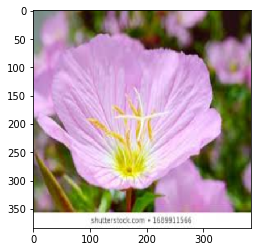

In [50]:
plt.imshow(img_fit[0])
plt.show()

In [56]:
f_distance,f_index = flower_index.search(test_emb,k=10)

In [57]:
print(f_distance[0])
print(f_index[0])

[184.24698 192.06879 197.92598 216.40051 217.3509  218.35596 221.08974
 221.52736 223.71964 226.85081]
[13244 16862 13090 15438   821 16293 16207 13227  7315 11503]


In [53]:
print(f_distance.shape, f_index.shape)

(1, 32) (1, 32)


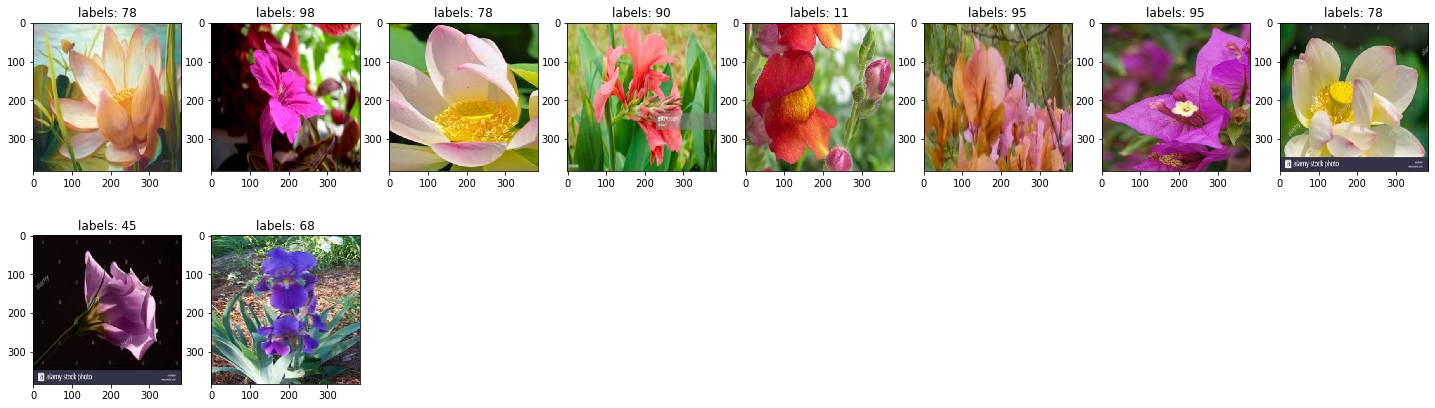

In [58]:
list_path = []

plt.figure(figsize=(25,15))
for i,j in enumerate(f_index[0]): 
    plt.subplot(4,8, i+1)
    img = x_train[j]
    list_path.append(x_train[j])
    image = Processing_Img(img)
    plt.title("labels: {}".format(img.split("/")[-2]))
    plt.imshow(image[0])
    

### Search by Cdist

In [64]:
from scipy.spatial.distance import cdist

In [65]:
path1 = '/home/manhduy/Documents/model_DL/Project_Intern/Data/102_flower_dataset/train/30/image_03460.jpg'
path2 = '/home/manhduy/Documents/model_DL/Project_Intern/Data/102_flower_dataset/train/30/image_03465.jpg'

In [77]:
img1 = Processing_Img(path1)
img2 = Processing_Img(path2)
emb1 = new_model.predict(img1)
emb2 = new_model.predict(img2)
emb1.shape

(1, 512)

In [81]:
Y = cdist(emb1, emb2, 'euclidean')
print(Y[0])

[29.75672611]


In [84]:
path_search = '/home/manhduy/Documents/model_DL/Project_Intern/test_image/image5.jpeg'

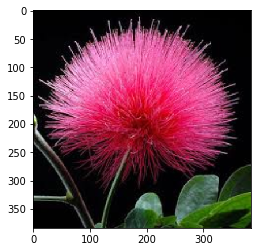

In [85]:
plt.imshow(Processing_Img(path_search)[0])

In [86]:
transform_image = new_model.predict(Processing_Img(path_search))

In [87]:
Distance = []

for index, path in enumerate(x_train): 
    emb = new_model.predict(Processing_Img(path))
    distance_caculate = cdist(emb,transform_image, 'euclidean')[0]
    Distance.append([distance_caculate,index])

In [93]:
sort_distance = sorted(Distance)

In [95]:
k = 10 
result_index = []

In [96]:
for i, tupble in enumerate(sort_distance): 
    result_index.append(tupble[1])
    if i == k: 
        break 

In [141]:
result_index

[4049, 4086, 4040, 4758, 4179, 4053, 4067, 4185, 4186, 4182, 4046]

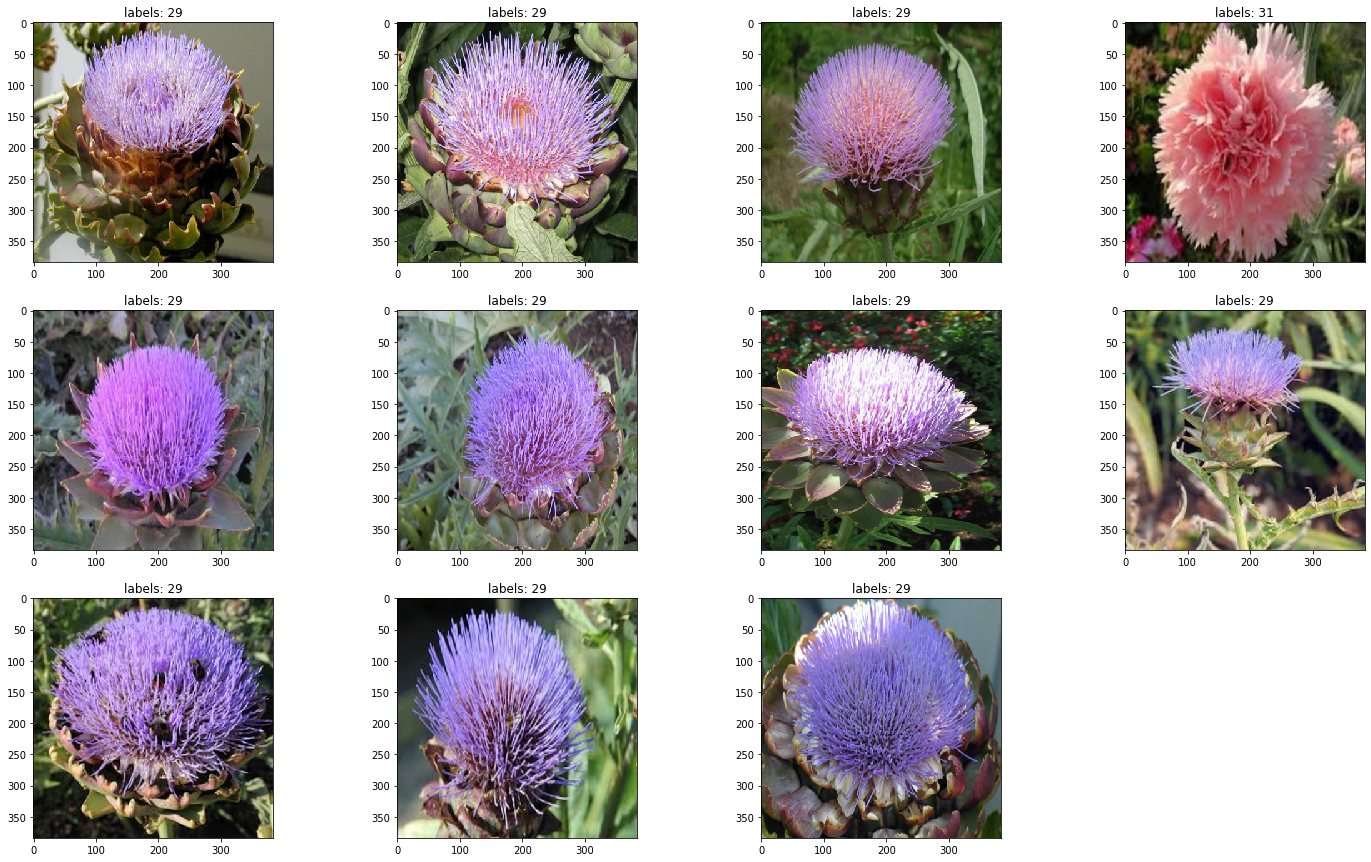

In [100]:
def show_sub_image(array_index):
    plt.figure(figsize=(25,15))
    for i,j in enumerate(array_index): 
        plt.subplot(3,4, i+1)
        path  = x_train[j]
        image = Processing_Img(path)[0]
        plt.title("labels: {}".format(path.split("/")[-2]))
        plt.imshow(image)
show_sub_image(result_index)

In [99]:
# def total_metrics(train_embs, train_labels, test_embs, test_labels, top_k=5):
#     topk_correct = 0
#     mapk = []
#     for emb, label in zip(test_embs, test_labels):
#         dists = cdist(np.expand_dims(emb, axis=0), train_embs, metric='euclidean')[0]
#         min_dist_indexes = dists.argsort()[:top_k]
#         pred_labels = train_labels[min_dist_indexes]
#         mapk.append(map_per_image(str(label), list(map(str, pred_labels))))

#         if label in pred_labels:
#             topk_correct += 1
    
#     topk_value = topk_correct / test_embs.shape[0]
#     mapk = np.mean(mapk)
#     print(">>> Top{} acc: {:.4f}".format(top_k, topk_value))
#     print(">>> Map@{}: {:.4f}".format(top_k, mapk))
    
#     return topk_value, mapk
# total_metrics(train_embs, train_labels, test_embs, test_labels, top_k=1);
# total_metrics(train_embs, train_labels, test_embs, test_labels, top_k=5);